# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [2]:
def crop_brain_contour(image, plot=False):
    
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

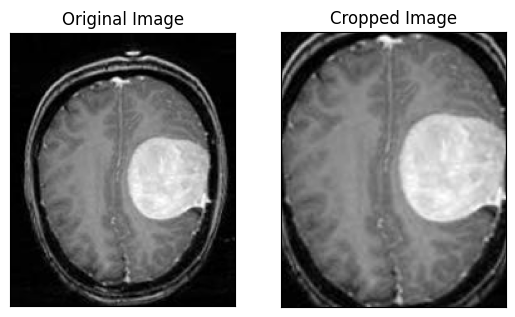

In [3]:
ex_img = cv2.imread('D:\\cryyy\\Brain-Tumor-Detection-master\\augmented data\\yes\\aug_Y1_0_2900.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [4]:
def load_data(dir_list, image_size):
   
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
   
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [7]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [9]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [93]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

In [10]:
def build_model(input_shape):
    
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) 
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    # FLATTEN X 
    X = Flatten()(X) 
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [11]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [12]:
model = build_model(IMG_SHAPE)

In [13]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

Let's train for a few more epochs:

In [16]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3
          0, validation_data=(X_val, y_val),callbacks = [early])
model.save("custommodel.h5")

Epoch 1/20
46/46 [==============================] - 166s 3s/step - loss: 0.7895 - accuracy: 0.6464 - val_loss: 0.6581 - val_accuracy: 0.6258
Epoch 2/20
46/46 [==============================] - 157s 3s/step - loss: 0.5171 - accuracy: 0.7522 - val_loss: 0.6497 - val_accuracy: 0.5419
Epoch 3/20
46/46 [==============================] - 151s 3s/step - loss: 0.4014 - accuracy: 0.8173 - val_loss: 0.6093 - val_accuracy: 0.6161
Epoch 4/20
46/46 [==============================] - 152s 3s/step - loss: 0.3384 - accuracy: 0.8602 - val_loss: 0.5163 - val_accuracy: 0.8000
Epoch 5/20
46/46 [==============================] - 168s 4s/step - loss: 0.3280 - accuracy: 0.8602 - val_loss: 0.5133 - val_accuracy: 0.7387
Epoch 6/20
46/46 [==============================] - 166s 4s/step - loss: 0.2934 - accuracy: 0.8768 - val_loss: 0.4335 - val_accuracy: 0.8129
Epoch 7/20
46/46 [==============================] - 164s 4s/step - loss: 0.2583 - accuracy: 0.8997 - val_loss: 0.3809 - val_accuracy: 0.8452
Epoch 8/20
46

In [17]:
history = model.history.history

## Plot Loss & Accuracy

In [86]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

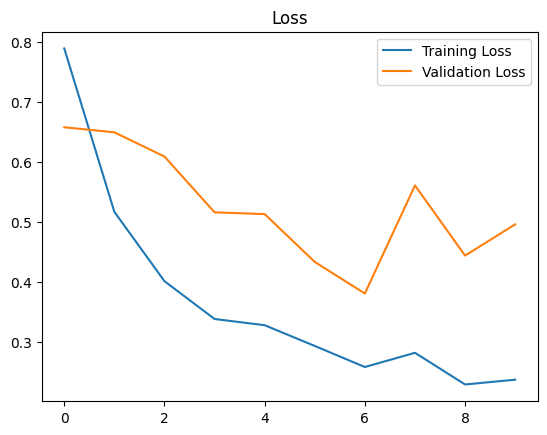

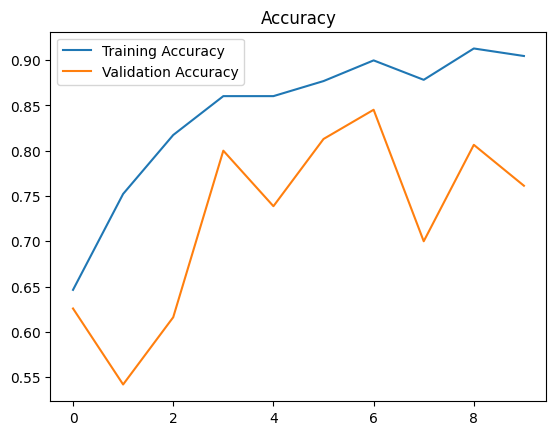

In [89]:
plot_metrics(history) 

# Results

### Load the best model

In [25]:
best_model = load_model(filepath='D:\\cryyy\\Brain-Tumor-Detection-master\\models\\cnn-parameters-improvement-23-0.91.model')

In [26]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [98]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 14s 1s/step - loss: 0.1489 - accuracy: 0.9581


In [29]:
loss, acc = best_model.evaluate(x=X_val, y=y_val)

10/10 [==============================] - 12s 1s/step - loss: 0.1423 - accuracy: 0.9581


### Accuracy of the best model on the testing data:

In [90]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1423240303993225
Test Accuracy = 0.9580644965171814


### F1 score for the best model on the testing data:

In [91]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 19s 2s/step


In [94]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9631728045325779


Let's also find the f1 score on the validation data:

In [65]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 8s 797ms/step


In [66]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8783382789317508


In [31]:
y_pred = best_model.predict(X_test)
y_pred_prob_test = np.where(y_pred > 0.5, 1, 0)

10/10 [==============================] - 22s 2s/step


In [131]:
# y_pred_prob_val = np.where(y_val_prob > 0.5, 1, 0)
# y_pred_prob_val
y_pred_train = best_model.predict(X_train)
y_pred_prob_train = np.where(y_pred_train > 0.5, 1, 0)


46/46 [==============================] - 44s 910ms/step


In [75]:
# test_img = cv2.imread('D:\\cryyy\\Brain-Tumor-Detection-master\\augmented data\\no\\aug_20 no_0_5063.jpg')
test_img = cv2.imread('D:\\cryyy\\Brain-Tumor-Detection-master\\augmented data\\no\\aug_21 no_0_74.jpg')
# test_img = cv2.imread('D:\\cryyy\\Brain-Tumor-Detection-master\\augmented data\\yes\\aug_Y2_0_3036.jpg')
# test_img = cv2.imread('D:\\cryyy\Brain-Tumor-Detection-master\\no\\No17.jpg')
# test_img = cv2.imread('D:\\cryyy\\Brain-Tumor-Detection-master\\yes\\Y3.jpg')
print(test_img.shape)
test_img1 = cv2.resize(test_img,(240,240))
image_array = np.array(test_img1)
image_array = image_array / 255.0 
test_img2=np.expand_dims(test_img1,axis=0)
test_img2.shape

(225, 225, 3)


(1, 240, 240, 3)

1/1 [==============================] - 0s 231ms/step
Tumor Not Found


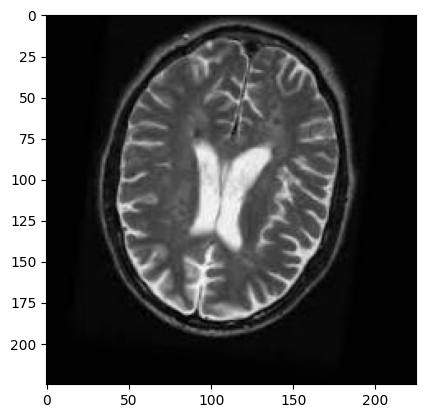

In [76]:
# model = tf.keras.models.load_model("D:\\cryyy\\Brain-Tumor-Detection-master\\models\\cnn-parameters-improvement-23-0.91.model")
model=load_model("D:\\cryyy\\Brain-Tumor-Detection-master\\models\\cnn-parameters-improvement-23-0.91.model")
prediction = model.predict(test_img2)
if prediction[0, 0] > 0.5:
    print("Tumor Found")
else:
    print("Tumor Not Found")
plt.imshow(test_img)

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [95]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [96]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [97]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 51.69550173010381%, number of pos examples: 747
Percentage of negative examples: 48.30449826989619%, number of neg examples: 698
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.645161290322584%, number of pos examples: 157
Percentage of negative examples: 49.354838709677416%, number of neg examples: 153
Testing Data:
Number of examples: 310
Percentage of positive examples: 58.38709677419355%, number of pos examples: 181
Percentage of negative examples: 41.61290322580645%, number of neg examples: 129


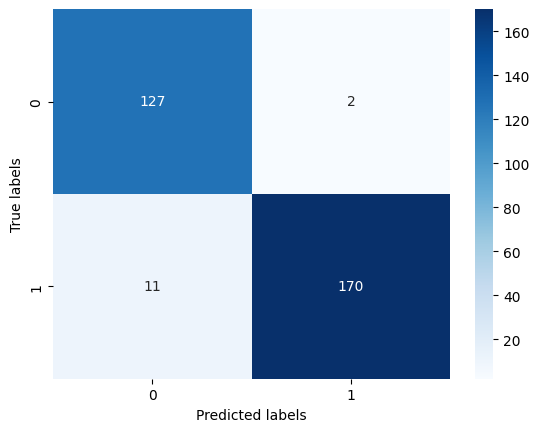

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get true labels and predicted labels from your model
# y_true = ... # true labels
# y_pred_prob_test = ... # predicted labels

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_prob_test)

# plot confusion matrix with classification
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
